In [1]:
import argparse
import cv2
import numpy as np
import torch
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/ldap/william/anaconda3/envs/pytorch_1_12/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Data Loader
class CSVDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, delimiter=' ', header=None)
        self.class_num = 15
        self.targets = self.img_labels.iloc[:, 1]
        # for i in range(len(self.targets)):
        #     if self.targets[i] > self.class_num:
        #         self.targets[i] = 0
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # image = Image.open(img_path)
        # if image.mode != 'RGB':
        #     image = image.convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        # image = np.array(image)
        if label > self.class_num:
            label = 0
        
        x = cv2.imread(img_path)
        # x = x[:, :, ::-1]
        
        if self.transform:
            image = self.transform(image=x)['image']
        return image, label

    def __len__(self):
        return len(self.img_labels)

SHAP_transforms = A.Compose([
        A.Resize(256, 256),
        A.CenterCrop(224, 224),
        A.Normalize(mean=[0.2527, 0.3085, 0.3082], std=[0.1234, 0.1629, 0.1564]),
        # A.Normalize(mean=[0.2266, 0.2886, 0.2763], std=[0.1125, 0.1538, 0.1363]),
        ToTensorV2()
    ])
train_set = CSVDataset('/hcds_vol/private/chrislin/AUO_Data_811_DA/train_Open_DA_ordered.csv', '/hcds_vol/private/chrislin/AUO_Data_811_DA', SHAP_transforms)
test_set = CSVDataset('/hcds_vol/private/chrislin/L5D/L5D_C101_C120_91_A/test_0802.csv', '/hcds_vol/private/chrislin/L5D/L5D_C101_C120_91_A', SHAP_transforms)
val_set = CSVDataset('/hcds_vol/private/chrislin/AUO_Data_811_DA/train_Open_DA_ordered.csv', '/hcds_vol/private/chrislin/AUO_Data_811_DA', SHAP_transforms)
# train_set = CSVDataset('/home/ldap/william/private/NCU/william/all_csv/chrislin/train.csv', '/home/ldap/william/private/chrislin/AUO_Data_811_DA', SHAP_transforms)
# test_set = CSVDataset('/home/ldap/william/private/NCU/william/all_csv/chrislin/test.csv', '/hcds_vol/private/chrislin/20230830_C101/', SHAP_transforms)
# test_set = CSVDataset('/hcds_vol/private/chrislin/AUO_Data_811_DA/val_Open_ordered.csv', '/hcds_vol/private/chrislin/AUO_Data_811_DA/', SHAP_transforms)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True, num_workers=24, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=False, num_workers=24, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=50, shuffle=False, num_workers=24, pin_memory=True)

In [3]:
import sys

# Load Model

repo_name = 'DER'
base_dir = os.path.realpath(".")[:os.path.realpath(".").index(repo_name) + len(repo_name)]
sys.path.insert(0, base_dir)

task_id = 2

import yaml
from inclearn.convnet import network
from torch.nn import DataParallel
from easydict import EasyDict as edict

    
# config_file = os.path.join(w_dir, "1.yaml")
config_file = "./configs/1.yaml"
with open(config_file, 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# device = "cuda:0"
device = "cpu"

cfg = edict(config)
model = network.BasicNet(
    cfg["convnet"],
    cfg = cfg,
    nf = cfg["channel"],
    device = device,
    use_bias = cfg["use_bias"],
    dataset = cfg["dataset"],
)
parallel_model = DataParallel(model)

total_classes = 28
increments = []
increments.append(cfg["start_class"])
for _ in range((total_classes - cfg["start_class"]) // cfg["increment"]):
    increments.append(cfg["increment"])

for i in range(task_id+1):
    model.add_classes(increments[i])
    model.task_size = increments[i]

if task_id == 0:
    state_dict = torch.load(f'./ckpts/step{task_id}.ckpt')
else:
    state_dict = torch.load(f'./ckpts/decouple_step{task_id}.ckpt')

parallel_model.cuda()
# parallel_model.to("cpu")
parallel_model.load_state_dict(state_dict)
parallel_model.eval()

2
Enable dynamical reprensetation expansion!
16
cpu
16
16


DataParallel(
  (module): BasicNet(
    (convnets): ModuleList(
      (0): ResNet(
        (conv1): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, 

In [4]:
# 得到模型的prediction
class ResnetPrediction(torch.nn.Module):
    def __init__(self, model):
        super(ResnetPrediction, self).__init__()
        self.model = model
    def forward(self, x):
        return self.model(x)['feature']
        
        # return self.model(x)['feature']
        # return self.model(x)

In [5]:
from tqdm import tqdm
import shap
from torch.autograd import Variable

# model
M = ResnetPrediction(parallel_model.module.cuda()).cuda()
train_feature = []
test_feature = []
with torch.no_grad():
    for batch_cnt, train_data in enumerate(train_loader):
        train_images, _ = train_data
        train_images = train_images.cuda()
        if batch_cnt == 0:
            train_feature = M(train_images)
        else:
            train_feature = torch.cat([train_feature,M(train_images)])
        if batch_cnt == 59:
            break

len(train_feature)

3000

In [6]:
explainer = shap.DeepExplainer(M.model.classifier, train_feature)

In [7]:
with torch.no_grad():
    for batch_cnt, val_data in enumerate(val_loader):
        val_images, _ = val_data
        val_images = val_images.cuda()
        if batch_cnt == 0:
            val_feature = M(val_images)
        else:
            val_feature = torch.cat([val_feature,M(val_images)])
len(val_feature)

In [9]:
val_shap_value = explainer.shap_values(val_feature)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


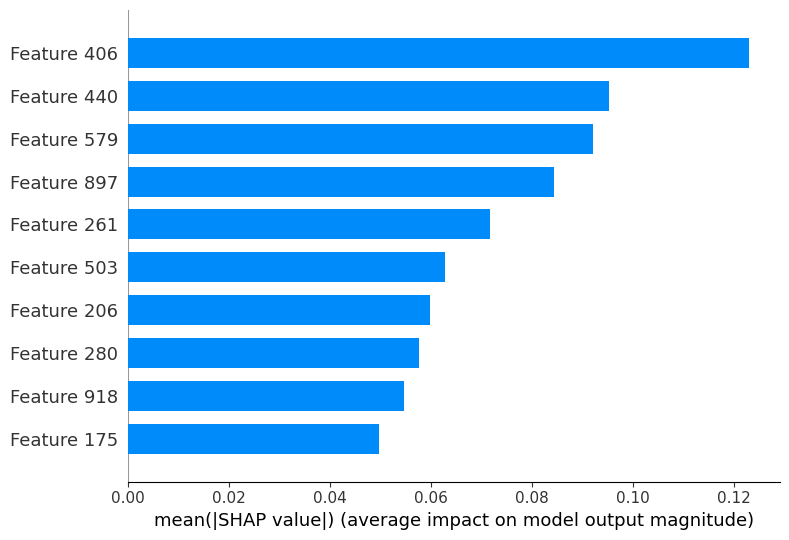

In [37]:
# val_index = [566,5046,8246,12086,14486,16086,16946,18549,19083,22139,23037,23537,24383,24883,25383,25883,27636,28136,28636,29136,29636]
# target_name = ["Others","I-Nothing","I-Others","E-M1-Al Residue","I-Dust","T-ITO1-Hole","T-M2-Fiber","I-Sand Defect","I-Glass Scratch","E-AS-Residue","I-Oil Like","E-ITO1-Hole",
#                         "P-ITO1-Residue","I-Laser Repair","P-AS-No","T-ITO1-Residue","E-M2-Residue","P-M2-Residue","T-Brush defect","T-AS-SiN Hole","T-AS-Particle Small",
#                         "P-M1-Residue"]
val = val_feature.cpu().detach().numpy()
val_shap_value = np.array(val_shap_value)

#others
# val_others = np.append(val[:566],val[29636:],axis=0)
# val_other_shap_value = np.append(val_shap_value[0][:566],val_shap_value[0][29636:],axis=0)
# shap.summary_plot(val_other_shap_value,val_others,max_display=10,plot_type="bar",show=False)
# plt.savefig('/home/ldap/william/private/NCU/william/DER/exps/opena_811_224_DA_DCL75_Jigsaw_7x7_Mixup_20230830_200/shap_images/Others.jpg')

#class1~21
for name,index in enumerate(val_index):  
    if name == 0:
        temp = index
    else:
        shap.summary_plot(val_shap_value[name][temp:index],val[temp:index],max_display=10,plot_type="bar",show=False)
        savepath = '/home/ldap/william/private/NCU/william/DER/exps/opena_811_224_DA_DCL75_Jigsaw_7x7_Mixup_20230830_200/shap_images/' + target_name[name] + '.jpg'
        plt.savefig(savepath)


In [17]:
class_val_shap_value = val_shap_value[2][7680:11520]
val_shap_value_mean = class_val_shap_value.mean(0)
z_negative = val_shap_value_mean.argsort()
z_postive = np.flipud(z_negative)
last20_val_shapvalue = z_negative[:10]
top20_val_shapvalue = z_postive[:10]
for i in top20_val_shapvalue:
    print('feature'+str(i)+' : ', val_shap_value_mean[i])
print('~~~~~~~~~~~~~~~~~~~~~~~')
for i in last20_val_shapvalue:
    print('feature'+str(i)+' : ', val_shap_value_mean[i])

feature261 :  0.19656926379494166
feature365 :  0.10006184490838071
feature324 :  0.09313845481275536
feature284 :  0.07235289053245708
feature8 :  0.04980491873413371
feature162 :  0.03644830728869124
feature383 :  0.016654737493681893
feature260 :  0.014060522480820717
feature350 :  0.012303998261492193
feature484 :  0.011843689838502532
~~~~~~~~~~~~~~~~~~~~~~~
feature181 :  -0.09223967905826763
feature152 :  -0.08586266288239368
feature151 :  -0.07157191093510416
feature385 :  -0.040941216260989205
feature426 :  -0.040168083254400244
feature406 :  -0.0344847712632126
feature175 :  -0.03326634430836926
feature401 :  -0.030904567961707603
feature242 :  -0.0308332370559782
feature509 :  -0.029901554586762084


In [15]:
#train_index 4480,7680,11520,13920,15520,16380,17983,18517,21573,22471,22971,23817,24317,24817,25317,27070
train_index = [4480,7680,11520,13920,15520,16380,17983,18517,21573,22471,22971,23817,24317,24817,25317,27070]
# test_index = [300,3802,5075,5152,5817,5947,6077,6382,6500,6605,6638,6646,6648,6664,6665,6667]
target_name = ["Others","I-Nothing","I-Others","E-M1-Al Residue","I-Dust","T-ITO1-Hole","T-M2-Fiber","I-Sand Defect","I-Glass Scratch","E-AS-Residue","I-Oil Like","E-ITO1-Hole",
                        "P-ITO1-Residue","I-Laser Repair","P-AS-No","T-ITO1-Residue"]
temp = 0
temp_csv = []
for k,i in enumerate(train_index):
    temp_ary = []
    if k == 0:
        temp = i
        others = np.concatenate((val_shap_value[0][:temp],val_shap_value[0][27070:]),0)
        v_shap_value_mean = others.mean(0)
    else:
        v_shap_value_mean = val_shap_value[k][temp:i].mean(0)
    z_ne = v_shap_value_mean.argsort()
    z_pos = np.flipud(z_ne)
    for j in z_pos[:10]:
        temp_ary.append(str(j))
        # temp_ary.append(['feature'+str(j),v_shap_value_mean[j]])
    for j in z_ne[:10]:
        temp_ary.append(str(j))
        # temp_ary.append(['feature'+str(j),v_shap_value_mean[j]])
    temp_csv.append(temp_ary)
    temp = i

result = pd.DataFrame(data = temp_csv)
result = result.T
result.columns = target_name
# result.to_csv('/hcds_vol/private/NCU/william/DER/exps/opena_811_224_DA_DCL75_Jigsaw_7x7_Mixup_20230830_200/result.csv')
print(result)

   Others I-Nothing I-Others E-M1-Al Residue I-Dust T-ITO1-Hole T-M2-Fiber  \
0     261       168      261             206    440         168        492   
1     206       175      365             181    100         261        405   
2     406       260      324              40     93         503        162   
3     180        67      284             202    162         417        350   
4     280       492        8              46    481         206        181   
5     100       503      162             492    469         152        180   
6     200       194      383             484    180         365        152   
7     324       202      260             178    175         180        321   
8     415       460      350             152    426          40         67   
9     469       385      484             280    206         280        280   
10    579       162      181             100    168         405        178   
11    152       481      152             440    415         484 